# Artificial Intelligence for Security: bonus assignment

##### by Alexander Stanimirov, S.M., D.F., L.C.

<div class="alert alert-block alert-success">
The dataset used in this assignment has to do with Android malware detection. We will mainly look at feature selection.
</div>

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = "path.csv"
df = pd.read_csv(file_path, header = 0)

C:\Users\Bearson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(10)

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,S
6,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,S
7,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
8,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,S
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,S


In [4]:
df.shape

(15036, 216)

In [5]:
df.dtypes

transact                       int64
onServiceConnected             int64
bindService                    int64
attachInterface                int64
ServiceConnection              int64
                               ...  
ACCESS_FINE_LOCATION           int64
SET_WALLPAPER_HINTS            int64
SET_PREFERRED_APPLICATIONS     int64
WRITE_SECURE_SETTINGS          int64
class                         object
Length: 216, dtype: object

In [6]:
df.columns

Index(['transact', 'onServiceConnected', 'bindService', 'attachInterface',
       'ServiceConnection', 'android.os.Binder', 'SEND_SMS',
       'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods',
       'Ljava.lang.Class.cast',
       ...
       'READ_CONTACTS', 'DEVICE_POWER', 'HARDWARE_TEST', 'ACCESS_WIFI_STATE',
       'WRITE_EXTERNAL_STORAGE', 'ACCESS_FINE_LOCATION', 'SET_WALLPAPER_HINTS',
       'SET_PREFERRED_APPLICATIONS', 'WRITE_SECURE_SETTINGS', 'class'],
      dtype='object', length=216)

In [7]:
df['class'].value_counts()

B    9476
S    5560
Name: class, dtype: int64

<div class="alert alert-block alert-success">
At first glance, we seem to be dealing with a medium-sized dataset consisting of a high amount of features (215) describing with a 0 (false) or 1 (true) whether or not there was some app permission (e.g. READ_CONTACTS) enabled or some Java method used, among other actions. Let's quickly verify that all columns contain just zeroes and ones.
</div>

In [8]:
for col in df.columns:
    df_grouped = df.groupby(col).size().reset_index(name='count')
    bools = {0, 1}
    if len(df_grouped[col].values) > 0 and len(set(df_grouped[col].values) - bools) > 0:
        print(df_grouped)

  TelephonyManager.getSimCountryIso  count
0                                 0   5514
1                                 1   1330
2                                 0   6994
3                                 1   1193
4                                 ?      5
  class  count
0     B   9476
1     S   5560


<div class="alert alert-block alert-success">
Only this column has some unexpected values: 1s and 0s as strings and 5 '?' values. We will change them appropriately instead of dropping the column outright - the few instances of ? could be changed to 0.
</div>

In [9]:
df['TelephonyManager.getSimCountryIso'] = df['TelephonyManager.getSimCountryIso'].apply(lambda x: 1 if x == '1' else 0)

In [10]:
df['TelephonyManager.getSimCountryIso'].value_counts()

0    13843
1     1193
Name: TelephonyManager.getSimCountryIso, dtype: int64

<div class="alert alert-block alert-success">
How could we go about trimming down the number of features before doing classification?
</div>

In [11]:
from sklearn.feature_selection import VarianceThreshold

In [12]:
X = df.drop('class', axis = 1)

<div class="alert alert-block alert-success">
Using VarianceThreshold as below is very convenient with boolean features, as the threshold we want is just the variance p(1-p), where we choose p such that very low variance features are removed, but also to simply limit the number of features for classification overall.
</div>

In [13]:
sel = VarianceThreshold(threshold=(.65 * (1 - .65)))
X = sel.fit_transform(X)
sel.fit_transform(df.drop('class', axis = 1))
X_cols = df[df.columns[sel.get_support(indices=True)]].columns

# We end up choosing p = 0.65, so remove all the columns that are either 1 or 0 in > 65% of samples.

In [14]:
len(X_cols)

34

In [15]:
X = pd.DataFrame(data=X[0:,0:], columns=X_cols[0:])

In [16]:
# quick check
X.columns == X_cols

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

<div class="alert alert-block alert-success">
Onto some classification with our first subset of features.
</div>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

In [19]:
import time

In [20]:
df['class'] = df['class'].apply(lambda x: 0 if x == 'B' else 1)

In [21]:
df['class'].value_counts()

0    9476
1    5560
Name: class, dtype: int64

In [22]:
def predict(model, X_test):
    return model.predict(X_test)

def evaluate(prediction, y_test):
    a = accuracy_score(prediction, y_test)
    p = precision_score(prediction, y_test)
    r = recall_score(prediction, y_test)
    c = confusion_matrix(y_test, prediction, labels=[0, 1])
    print("Accuracy: ", a, "\nPrecision: ", p, "\nRecall: ", r, "\nConfusion matrix:\n", c)

def train_logistic_regression(X_train, y_train):
    lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
    t0 = time.time()
    lr.fit(X_train, y_train)
    print("time to train = %.2f" % (time.time()-t0))
    return lr

def train_naive_bayes(X_train, y_train):
    nb = GaussianNB()
    t0 = time.time()
    nb.fit(X_train, y_train)
    print("time to train = %.2f" % (time.time()-t0))
    return nb

def train_decision_tree(X_train, y_train):
    dt = DecisionTreeClassifier()
    t0 = time.time()
    dt.fit(X_train, y_train)
    print("time to train = %.2f" % (time.time()-t0))
    return dt

def train_random_forest(X_train, y_train):
    rf = RandomForestClassifier(n_estimators = 20)
    t0 = time.time()
    rf.fit(X_train, y_train)
    print("time to train = %.2f" % (time.time()-t0))
    return rf

def train_svm(X_train, y_train):
    svm = SVC()
    t0 = time.time()
    svm.fit(X_train, y_train)
    print("time to train = %.2f" % (time.time()-t0))
    return svm

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, df['class'], test_size = 0.3)

In [24]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.18
Accuracy:  0.9006872090445578 
Precision:  0.8549848942598187 
Recall:  0.8718422674060382 
Confusion matrix:
 [[2648  208]
 [ 240 1415]]


In [25]:
print("RANDOM FOREST\n")
print("Training data performance:")
naive_bayes = train_naive_bayes(X_train, y_train)
evaluate(predict(naive_bayes, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 0.02
Accuracy:  0.7827532697849701 
Precision:  0.8942598187311178 
Recall:  0.6477024070021882 
Confusion matrix:
 [[2051  805]
 [ 175 1480]]


In [26]:
print("DECISION TREE\n")
print("Training data performance:")
decision_tree = train_decision_tree(X_train, y_train)
evaluate(predict(decision_tree, X_test), y_test)

DECISION TREE

Training data performance:
time to train = 0.07
Accuracy:  0.950565284859233 
Precision:  0.923262839879154 
Recall:  0.9408866995073891 
Confusion matrix:
 [[2760   96]
 [ 127 1528]]


In [27]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 0.34
Accuracy:  0.9609842606960762 
Precision:  0.9256797583081571 
Recall:  0.9665615141955836 
Confusion matrix:
 [[2803   53]
 [ 123 1532]]


In [28]:
print("SUPPORT VECTOR MACHINE\n")
print("Training data performance:")
svm = train_svm(X_train, y_train)
evaluate(predict(svm, X_test), y_test)

SUPPORT VECTOR MACHINE

Training data performance:


C:\Users\Bearson\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


time to train = 3.60
Accuracy:  0.9177565949900244 
Precision:  0.8652567975830816 
Recall:  0.9063291139240506 
Confusion matrix:
 [[2708  148]
 [ 223 1432]]


<div class="alert alert-block alert-success">
Some decent first results, but we believe we can do better. To help us with that, first let's take a look at which categories of features have the biggest impact on performance. The other provided sheet gives us the category-feature mappings.
</div>

In [29]:
file_path_categs = "C:/Users/Bearson/Desktop/Cyber Risk material/Artificial Intelligence for Security/data/data/AndroidMalware/dataset-features-categories.csv"
df_c = pd.read_csv(file_path_categs, names=['attribute', 'category'])

In [30]:
df_c.shape

(216, 2)

In [31]:
df_c['category'].unique()
# last one is irrelevant

array(['API call signature', 'Manifest Permission', 'Intent',
       'Commands signature', 'B=Benign; S=Malware'], dtype=object)

In [32]:
df_api = df_c[df_c['category'] == 'API call signature']['attribute']

In [33]:
print(len(np.array(df_api)))
print(np.array(df_api))

73
['transact' 'onServiceConnected' 'bindService' 'attachInterface'
 'ServiceConnection' 'android.os.Binder'
 'Ljava.lang.Class.getCanonicalName' 'Ljava.lang.Class.getMethods'
 'Ljava.lang.Class.cast' 'Ljava.net.URLDecoder'
 'android.content.pm.Signature' 'android.telephony.SmsManager' 'getBinder'
 'ClassLoader' 'Landroid.content.Context.registerReceiver'
 'Ljava.lang.Class.getField' 'Landroid.content.Context.unregisterReceiver'
 'Ljava.lang.Class.getDeclaredField' 'getCallingUid'
 'Ljavax.crypto.spec.SecretKeySpec' 'android.content.pm.PackageInfo'
 'KeySpec' 'TelephonyManager.getLine1Number' 'DexClassLoader'
 'HttpGet.init' 'SecretKey' 'Ljava.lang.Class.getMethod'
 'System.loadLibrary' 'android.intent.action.SEND' 'Ljavax.crypto.Cipher'
 'android.telephony.gsm.SmsManager' 'TelephonyManager.getSubscriberId'
 'Runtime.getRuntime' 'Ljava.lang.Object.getClass'
 'Ljava.lang.Class.forName' 'Binder' 'IBinder' 'android.os.IBinder'
 'createSubprocess' 'URLClassLoader' 'abortBroadcast'
 'Teleph

In [34]:
df_manifest = df_c[df_c['category'] == 'Manifest Permission']['attribute']

In [35]:
print(len(np.array(df_manifest)))
print(np.array(df_manifest))

113
['SEND_SMS' 'READ_PHONE_STATE' 'GET_ACCOUNTS' 'RECEIVE_SMS' 'READ_SMS'
 'USE_CREDENTIALS' 'MANAGE_ACCOUNTS' 'WRITE_SMS' 'READ_SYNC_SETTINGS'
 'AUTHENTICATE_ACCOUNTS' 'WRITE_HISTORY_BOOKMARKS' 'INSTALL_PACKAGES'
 'CAMERA' 'WRITE_SYNC_SETTINGS' 'READ_HISTORY_BOOKMARKS' 'INTERNET'
 'RECORD_AUDIO' 'NFC' 'ACCESS_LOCATION_EXTRA_COMMANDS'
 'WRITE_APN_SETTINGS' 'BIND_REMOTEVIEWS' 'READ_PROFILE'
 'MODIFY_AUDIO_SETTINGS' 'READ_SYNC_STATS' 'BROADCAST_STICKY' 'WAKE_LOCK'
 'RECEIVE_BOOT_COMPLETED' 'RESTART_PACKAGES' 'BLUETOOTH' 'READ_CALENDAR'
 'READ_CALL_LOG' 'SUBSCRIBED_FEEDS_WRITE' 'READ_EXTERNAL_STORAGE'
 'VIBRATE' 'ACCESS_NETWORK_STATE' 'SUBSCRIBED_FEEDS_READ'
 'CHANGE_WIFI_MULTICAST_STATE' 'WRITE_CALENDAR' 'MASTER_CLEAR'
 'UPDATE_DEVICE_STATS' 'WRITE_CALL_LOG' 'DELETE_PACKAGES' 'GET_TASKS'
 'GLOBAL_SEARCH' 'DELETE_CACHE_FILES' 'WRITE_USER_DICTIONARY'
 'REORDER_TASKS' 'WRITE_PROFILE' 'SET_WALLPAPER' 'BIND_INPUT_METHOD'
 'READ_SOCIAL_STREAM' 'READ_USER_DICTIONARY' 'PROCESS_OUTGOING_CALLS'
 

In [36]:
df_intent = df_c[df_c['category'] == 'Intent']['attribute']

In [37]:
print(len(np.array(df_intent)))
print(np.array(df_intent))

23
['android.intent.action.BOOT_COMPLETED'
 'android.intent.action.PACKAGE_REPLACED'
 'android.intent.action.SEND_MULTIPLE' 'android.intent.action.TIME_SET'
 'android.intent.action.PACKAGE_REMOVED'
 'android.intent.action.TIMEZONE_CHANGED'
 'android.intent.action.ACTION_POWER_DISCONNECTED'
 'android.intent.action.PACKAGE_ADDED'
 'android.intent.action.ACTION_SHUTDOWN'
 'android.intent.action.PACKAGE_DATA_CLEARED'
 'android.intent.action.PACKAGE_CHANGED'
 'android.intent.action.NEW_OUTGOING_CALL' 'android.intent.action.SENDTO'
 'android.intent.action.CALL' 'android.intent.action.SCREEN_ON'
 'android.intent.action.BATTERY_OKAY'
 'android.intent.action.PACKAGE_RESTARTED'
 'android.intent.action.CALL_BUTTON' 'android.intent.action.SCREEN_OFF'
 'intent.action.RUN' 'android.intent.action.SET_WALLPAPER'
 'android.intent.action.BATTERY_LOW'
 'android.intent.action.ACTION_POWER_CONNECTED']


In [38]:
df_commands = df_c[df_c['category'] == 'Commands signature']['attribute']

In [39]:
print(len(np.array(df_commands)))
print(np.array(df_commands))

6
['mount' 'chmod' 'remount' 'chown' '/system/bin' '/system/app']


<div class="alert alert-block alert-success">
We could train some classifiers using just features from a certain category and see which one(s) perform best.
</div>

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df[np.array(df_api)], df['class'], test_size = 0.3)

In [41]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.38
Accuracy:  0.9598758590113057 
Precision:  0.9265402843601895 
Recall:  0.9648365206662554 
Confusion matrix:
 [[2766   57]
 [ 124 1564]]


In [42]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 0.29
Accuracy:  0.9769452449567724 
Precision:  0.9508293838862559 
Recall:  0.9870848708487084 
Confusion matrix:
 [[2802   21]
 [  83 1605]]


In [43]:
X_train, X_test, y_train, y_test = train_test_split(df[np.array(df_manifest)], df['class'], test_size = 0.3)

In [44]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.42
Accuracy:  0.9235202837508313 
Precision:  0.856892523364486 
Recall:  0.9361837906828334 
Confusion matrix:
 [[2699  100]
 [ 245 1467]]


In [45]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 0.41
Accuracy:  0.9547772112613612 
Precision:  0.9117990654205608 
Recall:  0.9671623296158612 
Confusion matrix:
 [[2746   53]
 [ 151 1561]]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(df[np.array(df_intent)], df['class'], test_size = 0.3)

In [47]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.14
Accuracy:  0.7807581467523831 
Precision:  0.6340579710144928 
Recall:  0.732728541521284 
Confusion matrix:
 [[2472  383]
 [ 606 1050]]


In [48]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 0.21
Accuracy:  0.7936156062957216 
Precision:  0.6467391304347826 
Recall:  0.7558221594918842 
Confusion matrix:
 [[2509  346]
 [ 585 1071]]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(df[np.array(df_commands)], df['class'], test_size = 0.3)

In [50]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.06
Accuracy:  0.634449124362669 
Precision:  0.6133567662565905 
Recall:  0.5142436149312377 
Confusion matrix:
 [[1815  989]
 [ 660 1047]]


In [51]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 0.13
Accuracy:  0.6670361338949236 
Precision:  0.6625659050966608 
Recall:  0.5498298492950899 
Confusion matrix:
 [[1878  926]
 [ 576 1131]]


<div class="alert alert-block alert-success">
The best category seems to be 'API call signature', only just beating 'Manifest Permission', which also contains 40 more features. However, we cannot yet say for sure that the other two categories, which have fewer features, are less important - it might be that specific subsets of features turn out to be the most predictive of the class. So we could try some more feature selection on increasingly larger subsets and see whether or not performance depends on just the category and if there is some "cut-off" point where classifier accuracy doesn't <i>substantially</i> improve by adding more and more features.
</div>

<div class="alert alert-block alert-success">
One way to reduce the number of features is through recursive feature elimination. RFE fits the model starting with all the features and eliminating the weakest features one-by-one (or by several at a time) until the best subset of features is attained. (Source: https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html)
</div>

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel

In [53]:
X = df.drop('class',axis=1)
y = df['class']

In [54]:
# Reduce feature count to 10

t0 = time.time()
rfe = RFE(SVC(kernel='linear'), 10, step=1)
rfe = rfe.fit(X, y)
print("Time to train RFE: ", time.time()-t0)

# Could have used a larger step

Time to train RFE:  915.1621780395508


In [55]:
rfe.ranking_

array([142,   2,  84, 105,  80, 128,  10,   3, 115, 196,  19, 183,  31,
        33, 101,  44, 179, 146,  17,  34, 188,  61,  63,   1,  30,  42,
         1,  64, 182, 160,  26, 161,  87,  62, 116,  12,   9, 159,  93,
       147, 184,   1,  68,  20, 178, 156,  70, 130, 107, 193,   8,  60,
        32,   1, 177, 151, 169,  15, 143,  11,   1, 129,  27, 170,  96,
         1,  51,  25,   5,  52, 176,  43,  53, 154,   1, 168, 180, 111,
       195,   4, 126, 103, 141,  49, 153,   1, 144,  81, 190,  54,  36,
       162,  47,   1,  37, 171,  35,  39, 127, 135,  94, 121, 123,  38,
        50,  72,   7, 138,  92,  88,  58,  73, 174, 133,  28,  76, 150,
       165,  69,  89, 201,  86, 125,  79, 205,  78, 109,  16,  48,  67,
        74, 139,  24,  59, 108, 191, 200, 114, 167,  82,  66,  95, 197,
        77,   1,  90, 112, 187, 202,  75,  99, 137,  22,  71,  18,  14,
       206, 189, 204, 186, 100, 117,  21, 102,  57, 198, 110,  98,  83,
       132, 158,  29, 157,   6, 164, 118, 155, 172, 104,  41,  9

In [57]:
support= rfe.get_support()
selected_features = []

for bool, feature in zip(support, df.columns):
    if bool:
        selected_features.append(feature)

In [58]:
print(selected_features)

['getCallingUid', 'USE_CREDENTIALS', 'android.telephony.gsm.SmsManager', 'android.intent.action.PACKAGE_REPLACED', 'NFC', 'BIND_REMOTEVIEWS', 'android.intent.action.TIMEZONE_CHANGED', 'Runtime.load', 'sendMultipartTextMessage', 'WRITE_GSERVICES']


<div class="alert alert-block alert-success">
Now that we have a reduced set of just 10 features selected by RFE without the cross-validation step, we can try running some classifiers and see how they perform.
</div>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], y, test_size=0.25)

In [60]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.05
Accuracy:  0.6656025538707103 
Precision:  0.11158493248045487 
Recall:  0.9573170731707317 
Confusion matrix:
 [[2345    7]
 [1250  157]]


In [61]:
print("NAIVE BAYES\n")
print("Training data performance:")
naive_bayes = train_naive_bayes(X_train, y_train)
evaluate(predict(naive_bayes, X_test), y_test)

NAIVE BAYES

Training data performance:
time to train = 0.01
Accuracy:  0.6461824953445066 
Precision:  0.9893390191897654 
Recall:  0.514222386405615 
Confusion matrix:
 [[1037 1315]
 [  15 1392]]


In [62]:
print("DECISION TREE\n")
print("Training data performance:")
decision_tree = train_decision_tree(X_train, y_train)
evaluate(predict(decision_tree, X_test), y_test)

DECISION TREE

Training data performance:
time to train = 0.01
Accuracy:  0.6671987230646449 
Precision:  0.11158493248045487 
Recall:  0.9936708860759493 
Confusion matrix:
 [[2351    1]
 [1250  157]]


In [63]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 0.14
Accuracy:  0.6669326948656558 
Precision:  0.11087420042643924 
Recall:  0.9936305732484076 
Confusion matrix:
 [[2351    1]
 [1251  156]]


In [64]:
print("SUPPORT VECTOR MACHINE\n")
print("Training data performance:")
svm = train_svm(X_train, y_train)
evaluate(predict(svm, X_test), y_test)

SUPPORT VECTOR MACHINE

Training data performance:


C:\Users\Bearson\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


time to train = 4.47
Accuracy:  0.6671987230646449 
Precision:  0.11300639658848614 
Recall:  0.9814814814814815 
Confusion matrix:
 [[2349    3]
 [1248  159]]


<div class="alert alert-block alert-success">
The results aren't very promising, especially in terms of accuracy and FPR.
<div>

<div class="alert alert-block alert-success">
At this point we decide try some more sophisticated feature selection and dimensionality reduction with the help of grid search and a couple of new algorithms: principal component analysis, and SelectKBest.
    <br>
    <br>PCA can be used to reduce a large set of variables to a small set while retaining (most of) the original information. The resulting small set contains the uncorrelated 'principal components' (linear combinations of the original features), where the first component should have the largest possible variance. (Source: https://en.wikipedia.org/wiki/Principal_component_analysis)
    <br>
    <br>SelectKBest simply chooses the k-best features based on the score of some statistical test. Here, we'll use a chi-squared test.
    <br>
    <br>To prepare for our grid search, we will prepare a random forest classifier with several options for number of estimators, provide a reduced feature count ranging from 10 all the way to 200, and use 3-fold CV.
</div>

In [65]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

In [67]:
X = df.drop('class',axis=1)
y = df['class']

In [66]:
pipeline = Pipeline([
    ('dim_reduction', 'passthrough'),
    ('classification', RandomForestClassifier())
])

n_features = [10, 50, 120, 200]
estimators = [100, 150, 250]
params = [
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': n_features,
        'classification__n_estimators': estimators
    },
    {
        'dim_reduction': [SelectKBest(chi2)],
        'dim_reduction__k': n_features,
        'classification__n_estimators': estimators
    },
]

grid = GridSearchCV(pipeline, param_grid=params, cv=3)

In [68]:
t0 = time.time()
grid.fit(X, y)
print("GridSearchCV fitting complete in: ", time.time()-t0)

GridSearchCV fitting complete in:  604.0589122772217


In [69]:
print(grid.best_params_)

{'classification__n_estimators': 250, 'dim_reduction': SelectKBest(k=200, score_func=<function chi2 at 0x000001A876665B88>), 'dim_reduction__k': 200}


<div class="alert alert-block alert-success">
GridSearchCV results show SelectKBest with k = 200 and 250 estimators for the random forest to be the highest-scoring combination. Let's take a look at the overall scores from the entire CV:
</div>

In [70]:
scores = np.array(grid.cv_results_['mean_test_score'])
print(scores)

[0.97698856 0.98024741 0.97845172 0.97592445 0.97772014 0.98004789
 0.97798617 0.97585794 0.97752062 0.98091248 0.9783187  0.97619048
 0.83240223 0.97253259 0.98410482 0.98649907 0.83220271 0.96714552
 0.98483639 0.9867651  0.83200319 0.97253259 0.98476989 0.98709763]


In [71]:
scores = scores.reshape(len(estimators), -1, len(n_features))
print(scores)

[[[0.97698856 0.98024741 0.97845172 0.97592445]
  [0.97772014 0.98004789 0.97798617 0.97585794]]

 [[0.97752062 0.98091248 0.9783187  0.97619048]
  [0.83240223 0.97253259 0.98410482 0.98649907]]

 [[0.83220271 0.96714552 0.98483639 0.9867651 ]
  [0.83200319 0.97253259 0.98476989 0.98709763]]]


In [72]:
scores_min = scores.min(axis=0)
scores_max = scores.max(axis=0)
print(scores_min)
print(scores_max)

[[0.83220271 0.96714552 0.9783187  0.97592445]
 [0.83200319 0.97253259 0.97798617 0.97585794]]
[[0.97752062 0.98091248 0.98483639 0.9867651 ]
 [0.97772014 0.98004789 0.98476989 0.98709763]]


<div class="alert alert-block alert-success">
The minimum score of 0.83 stands out as being substantially lower than the rest; to be safe we could just use all the minimum scores to compare the results.
</div>

In [73]:
scores = scores_min

In [74]:
dim_reduc_type = ['PCA', 'KBest(chi2)']
height = (np.arange(len(n_features)) * (len(dim_reduc_type) + 1) + .5)

In [75]:
import matplotlib.pyplot as plt

C:\Users\Bearson\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  after removing the cwd from sys.path.


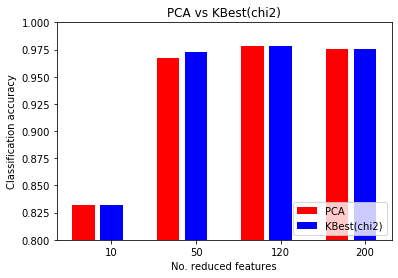

In [76]:
plt.figure()
colors = 'RB'
for i, (name, score) in enumerate(zip(dim_reduc_type, scores)):
    plt.bar(height + i, score, label=name, color=colors[i])
    
plt.title("PCA vs KBest(chi2)")
plt.xlabel('No. reduced features')
plt.xticks(height + len(dim_reduc_type) / 2, n_features)
plt.ylabel('Classification accuracy')
plt.ylim((0.80, 1))
plt.legend(loc='lower right')

plt.show()

<div class="alert alert-block alert-success">
With just 10 features, the minimum score hovers around 0.83, whereas with 50 features we already see a substantial improvement, and it doesn't improve much more after that. KBest beats out PCA, but only by a little bit.
</div>

<div class="alert alert-block alert-success">
Having visualized the results, let's repeat a SelectKBest with a k of 50 to see which columns are chosen, and see if the other classifiers makes as accurate predictions as the random forest's.
</div>

In [77]:
X = df.drop('class',axis=1)
y = df['class']

In [78]:
sel = SelectKBest(chi2, k=50)
X_redux = sel.fit_transform(X, y)
sel.fit_transform(df.drop('class', axis = 1), y)
X_redux_cols = df[df.columns[sel.get_support(indices=True)]].columns

In [88]:
len(X_redux_cols)
print(X_redux_cols)

Index(['transact', 'onServiceConnected', 'bindService', 'attachInterface',
       'ServiceConnection', 'android.os.Binder', 'SEND_SMS',
       'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods',
       'Ljava.lang.Class.cast', 'Ljava.net.URLDecoder',
       'android.content.pm.Signature', 'android.telephony.SmsManager',
       'READ_PHONE_STATE', 'getBinder', 'ClassLoader',
       'Landroid.content.Context.registerReceiver',
       'Ljava.lang.Class.getField',
       'Landroid.content.Context.unregisterReceiver', 'GET_ACCOUNTS',
       'RECEIVE_SMS', 'Ljava.lang.Class.getDeclaredField', 'READ_SMS',
       'getCallingUid', 'Ljavax.crypto.spec.SecretKeySpec',
       'android.intent.action.BOOT_COMPLETED', 'USE_CREDENTIALS',
       'MANAGE_ACCOUNTS', 'KeySpec', 'TelephonyManager.getLine1Number',
       'DexClassLoader', 'HttpGet.init', 'SecretKey',
       'Ljava.lang.Class.getMethod', 'System.loadLibrary',
       'android.intent.action.SEND', 'Ljavax.crypto.Cipher', 'WRITE

In [80]:
X_redux = pd.DataFrame(data=X_redux[0:,0:], columns=X_redux_cols[0:])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_redux, y, test_size=0.25)

In [82]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.35
Accuracy:  0.942537909018356 
Precision:  0.9082633053221288 
Recall:  0.9384949348769899 
Confusion matrix:
 [[2246   85]
 [ 131 1297]]


In [83]:
print("NAIVE BAYES\n")
print("Training data performance:")
naive_bayes = train_naive_bayes(X_train, y_train)
evaluate(predict(naive_bayes, X_test), y_test)

NAIVE BAYES

Training data performance:
time to train = 0.04
Accuracy:  0.836658685820697 
Precision:  0.9656862745098039 
Recall:  0.7093621399176955 
Confusion matrix:
 [[1766  565]
 [  49 1379]]


In [84]:
print("DECISION TREE\n")
print("Training data performance:")
decision_tree = train_decision_tree(X_train, y_train)
evaluate(predict(decision_tree, X_test), y_test)

DECISION TREE

Training data performance:
time to train = 0.11
Accuracy:  0.9643522213354616 
Precision:  0.9509803921568627 
Recall:  0.9549929676511955 
Confusion matrix:
 [[2267   64]
 [  70 1358]]


In [85]:
# Just checking RF's performance with n_estimators = 250

def train_random_forest(X_train, y_train):
    rf = RandomForestClassifier(n_estimators = 250)
    t0 = time.time()
    rf.fit(X_train, y_train)
    print("time to train = %.2f" % (time.time()-t0))
    return rf

In [86]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 3.31
Accuracy:  0.9731311519021016 
Precision:  0.9537815126050421 
Recall:  0.9749463135289907 
Confusion matrix:
 [[2296   35]
 [  66 1362]]


In [87]:
print("SUPPORT VECTOR MACHINE\n")
print("Training data performance:")
svm = train_svm(X_train, y_train)
evaluate(predict(svm, X_test), y_test)

SUPPORT VECTOR MACHINE

Training data performance:


C:\Users\Bearson\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


time to train = 4.09
Accuracy:  0.9462623038042033 
Precision:  0.8907563025210085 
Recall:  0.9650986342943855 
Confusion matrix:
 [[2285   46]
 [ 156 1272]]


<div class="alert alert-block alert-success">
The accuracy scores, as expected, are high, but the precision still leaves something to be desired. In all likelihood, a higher number of features can improve the precision score.
</div>

In [123]:
X = df.drop('class', axis=1)
y = df['class']

In [127]:
sel = SelectKBest(chi2, k=200)
X_large = sel.fit_transform(X, y)
sel.fit_transform(df.drop('class', axis = 1), y)
X_large_cols = df[df.columns[sel.get_support(indices=True)]].columns

In [130]:
print(len(X_large_cols))
print(X_large_cols)

200
Index(['transact', 'onServiceConnected', 'bindService', 'attachInterface',
       'ServiceConnection', 'android.os.Binder', 'SEND_SMS',
       'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods',
       'Ljava.lang.Class.cast',
       ...
       'Runtime.loadLibrary', 'BROADCAST_SMS', 'EXPAND_STATUS_BAR',
       'INTERNAL_SYSTEM_WINDOW', 'android.intent.action.BATTERY_LOW',
       'SET_ACTIVITY_WATCHER', 'WRITE_CONTACTS',
       'android.intent.action.ACTION_POWER_CONNECTED', 'DISABLE_KEYGUARD',
       'ACCESS_MOCK_LOCATION'],
      dtype='object', length=200)


In [129]:
X_large = pd.DataFrame(data=X_large[0:,0:], columns=X_large_cols[0:])

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_large, y, test_size=0.25)

In [132]:
print("LOGISTIC REGRESSION\n")
print("Training data performance:")
logistic_regression = train_logistic_regression(X_train, y_train)
evaluate(predict(logistic_regression, X_test), y_test)

LOGISTIC REGRESSION

Training data performance:
time to train = 0.67
Accuracy:  0.9760574620909817 
Precision:  0.9593908629441624 
Recall:  0.9749447310243183 
Confusion matrix:
 [[2346   34]
 [  56 1323]]


In [133]:
print("NAIVE BAYES\n")
print("Training data performance:")
naive_bayes = train_naive_bayes(X_train, y_train)
evaluate(predict(naive_bayes, X_test), y_test)

NAIVE BAYES

Training data performance:
time to train = 0.10
Accuracy:  0.6951316839584996 
Precision:  0.981145757795504 
Recall:  0.5471087747674889 
Confusion matrix:
 [[1260 1120]
 [  26 1353]]


In [134]:
print("DECISION TREE\n")
print("Training data performance:")
decision_tree = train_decision_tree(X_train, y_train)
evaluate(predict(decision_tree, X_test), y_test)

DECISION TREE

Training data performance:
time to train = 0.37
Accuracy:  0.9744612928970471 
Precision:  0.9724437998549673 
Recall:  0.958541815582559 
Confusion matrix:
 [[2322   58]
 [  38 1341]]


In [135]:
print("RANDOM FOREST\n")
print("Training data performance:")
random_forest = train_random_forest(X_train, y_train)
evaluate(predict(random_forest, X_test), y_test)

RANDOM FOREST

Training data performance:
time to train = 5.94
Accuracy:  0.9869646182495344 
Precision:  0.9731689630166788 
Recall:  0.9911373707533235 
Confusion matrix:
 [[2368   12]
 [  37 1342]]


In [136]:
print("SUPPORT VECTOR MACHINE\n")
print("Training data performance:")
svm = train_svm(X_train, y_train)
evaluate(predict(svm, X_test), y_test)

SUPPORT VECTOR MACHINE

Training data performance:


C:\Users\Bearson\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


time to train = 9.77
Accuracy:  0.9683426443202979 
Precision:  0.9347353154459753 
Recall:  0.9779969650986343 
Confusion matrix:
 [[2351   29]
 [  90 1289]]


<div class="alert alert-block alert-success">
Our hypothesis seems to be correct. Perhaps it is worth training nearly all of the features together at the same time!
</div>

<div class="alert alert-block alert-success">
Finally, let's do some clustering on the data to see how well malware instances cluster together.
</div>

In [89]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [90]:
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score
)

<div class="alert alert-block alert-success">
Feature selection for clustering proved to be quite a challenge. We started with large subsets of features but got poor results, and we eventually settled on a subset of just 3 features which we previously saw to have fairly high variance.
</div>

In [104]:
print(selected_features)
print(X_cols)

['getCallingUid', 'USE_CREDENTIALS', 'android.telephony.gsm.SmsManager', 'android.intent.action.PACKAGE_REPLACED', 'NFC', 'BIND_REMOTEVIEWS', 'android.intent.action.TIMEZONE_CHANGED', 'Runtime.load', 'sendMultipartTextMessage', 'WRITE_GSERVICES']
Index(['transact', 'onServiceConnected', 'bindService', 'attachInterface',
       'ServiceConnection', 'android.os.Binder', 'Ljava.net.URLDecoder',
       'android.content.pm.Signature', 'READ_PHONE_STATE', 'ClassLoader',
       'Landroid.content.Context.registerReceiver',
       'Ljava.lang.Class.getField',
       'Landroid.content.Context.unregisterReceiver',
       'Ljava.lang.Class.getDeclaredField', 'Ljavax.crypto.spec.SecretKeySpec',
       'android.intent.action.BOOT_COMPLETED', 'KeySpec', 'HttpGet.init',
       'SecretKey', 'Ljava.lang.Class.getMethod', 'System.loadLibrary',
       'Ljavax.crypto.Cipher', 'mount', 'Runtime.getRuntime',
       'Ljava.lang.Class.forName', 'TelephonyManager.getDeviceId', 'WAKE_LOCK',
       'RECEIVE_BOOT_

In [105]:
t0 = time.time()
agglom = AgglomerativeClustering(n_clusters=2, affinity='jaccard', linkage='complete').fit(df[['transact', 'android.telephony.gsm.SmsManager', 'onServiceConnected']])
print("time to train: ", time.time() - t0)

time to train:  9.67254900932312


In [106]:
agglom.labels_

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [107]:
df['agglom_cluster'] = agglom.labels_

In [108]:
df.groupby(['class', 'agglom_cluster']).size()

class  agglom_cluster
0      0                 3439
       1                 6037
1      0                 5340
       1                  220
dtype: int64

In [109]:
pred_clusters = df['agglom_cluster'].values
true_labels = df['class'].values

In [110]:
print(homogeneity_score(true_labels, pred_clusters))
print(completeness_score(true_labels, pred_clusters))
print(v_measure_score(true_labels, pred_clusters))

0.3105099867697438
0.3012837726023688
0.30582731128448454


In [111]:
t0 = time.time()
dbscan = DBSCAN(eps=0.1, min_samples=20, metric='jaccard').fit(df[['transact', 'android.telephony.gsm.SmsManager', 'onServiceConnected']])
print("time to train: ", time.time() - t0)

time to train:  4.3431079387664795


In [112]:
dbscan.labels_

array([0, 0, 0, ..., 0, 5, 5], dtype=int64)

In [113]:
df['dbscan_cluster'] = dbscan.labels_

In [114]:
df.groupby(['class', 'dbscan_cluster']).size()

class  dbscan_cluster
0      -1                   6
        0                2809
        1                 570
        2                   3
        3                 404
        4                  48
        5                5633
        6                   3
1      -1                   1
        0                4457
        1                 277
        2                 501
        3                 116
        4                  76
        5                 104
        6                  28
dtype: int64

In [115]:
pred_clusters = df['dbscan_cluster'].values
true_labels = df['class'].values

In [116]:
print(homogeneity_score(true_labels, pred_clusters))
print(completeness_score(true_labels, pred_clusters))
print(v_measure_score(true_labels, pred_clusters))

0.36472559517679143
0.20588009977611746
0.2631931037144614


<div class="alert alert-block alert-success">
Malware instances seem to share clusters with non-malware instances a lot of the time. DBSCAN seems to have produced a couple of relatively homogenous ones, however (2 and 5).
</div>

<div class="alert alert-block alert-success">
This is the end of the second notebook! Thank you again for sticking with us.
</div>